---
title: Logistic Regression
author: Julia Joy
date: '2024-04-12'
image: "image.jpg"
description: "Blog Post 5: Implementing Logistic Regression"
---

### Abstract 
In this blog post, I implement and experiment with gradient descent algorithms for logistic regression. I conducted three experiments, implementing Vanilla Gradient Descent, experiments to understand the benefits of momentum, and a final experiment to understand the dangers and harms of overfitting the logistic regression model on training data. I was able to make several meaningful conclusions. Implementing Vanilla Gradient Descent where beta =0 led to convergence with monotonically decreasing loss, however with benefits of momentum, such as where beta = 0.9, loss decreased at a faster rate, converging with fewer iterations than needed for Vanilla Gradient Descent. The experiment in which I fit the model too closely to the training data showed lower accuracy on the test data, warning against overfitting. I was able to learn more about logistic regression as a machine learning model throughout the implementation and exploration of this blog post. 


### Part A: Implementing Logistic Regression 
The code for implementing logistic regression is done in logistic.py. 

In [78]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Part B: Experiments

In order to perform experiments with my implemented logistic regression model, first data needs to be generated. I used provided class code to do so, generating 2D data. 

In [79]:
import torch 
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

## Vanilla Gradient Descent 
The first experiment I performed was vanilla gradient descent. 
When there are 2 dimensions, alpha is sufficently small, and beta is 0, I expect to see gradient descent for logistic regression converge to a weight vector w, the loss decreasing monotonically (either only increasing or only decreasing). 

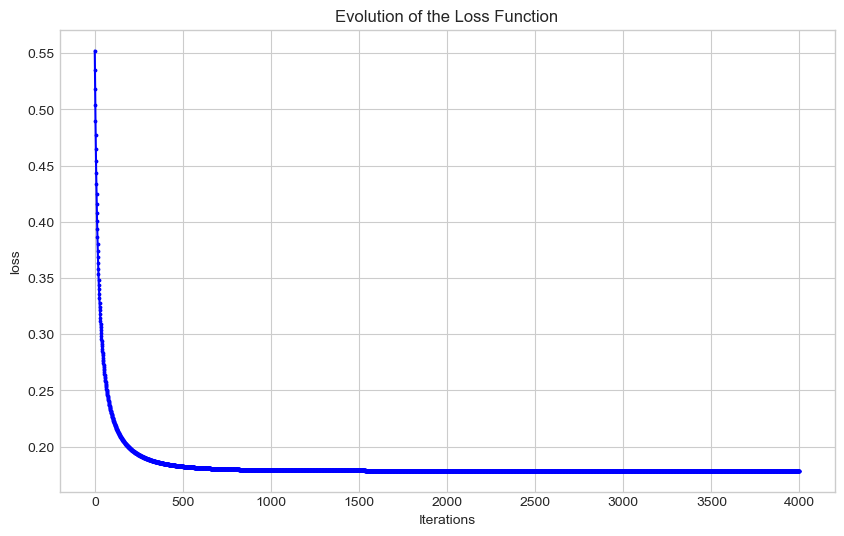

In [80]:
import numpy as np
import matplotlib.pyplot as plt

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

lossVec = [] 

for _ in range(4000):
    # VGD alpha small and beta 0 
    opt.step(X, y, alphaRate = 0.4, betaRate = 0)
    loss = LR.loss(X,y)
    lossVec.append(loss)


#then plot loss over iterations, v similar to how we did in the perceptron blog post 
def plotLoss(loss, label =""):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(lossVec, color = "blue", label = label)
    plt.scatter(torch.arange(len(loss)), loss, color = "blue", s=3)
    plt.gca().set(xlabel = "Iterations", ylabel = "loss")
    
    plt.title(f"Evolution of the Loss Function")
    #check final loss value as a means of verifying model 
    finalLossVal = loss[len(loss)-1]

plotLoss(lossVec)


From the plot, we can see that the loss is decreasing the entire time (and thus loss decreasing monotonically!), in line with our expected behavior of vanilla gradient descent. 
We can further visualize the result of the model by plotting the data with its new decision boundary. 

Text(0.5, 1.0, 'loss = 0.179')

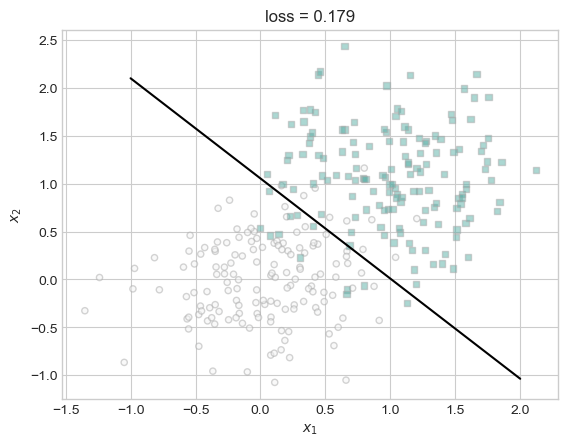

In [81]:
def drawLine(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plotData (X, y, ax):
    #from perceptron blog post, but targets now 0,1 for binary classification
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
fig, ax = plt.subplots(1, 1)
plotData(X, y, ax)
drawLine(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
#checking the final loss to verify model
ax.set_title(f"loss = {loss:.3f}")

The model did a good job of finding a separating line between the two distinct classes, with the final loss being around 0.1. 

### Benefits of Momentum 

The next experiment I performed was to show the benefits of momentum. On the same data, we expect to see gradient descent with momentum (when beta is a non-zero value such as 0.9) is able to converge to the correct weight vector faster, in fewer iterations than the previous experiment of vanilla gradient descent (where beta = 0). 

In [82]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
X, y = classification_data(noise = 0.2)

# initialize for main loop
lossVecMomentum = []

for index in range(4000):
    # alpha small and beta nonzero = 0.9
    opt.step(X, y, alphaRate = 0.4, betaRate = 0.9)
    loss = LR.loss(X, y)      
    lossVecMomentum.append(loss)

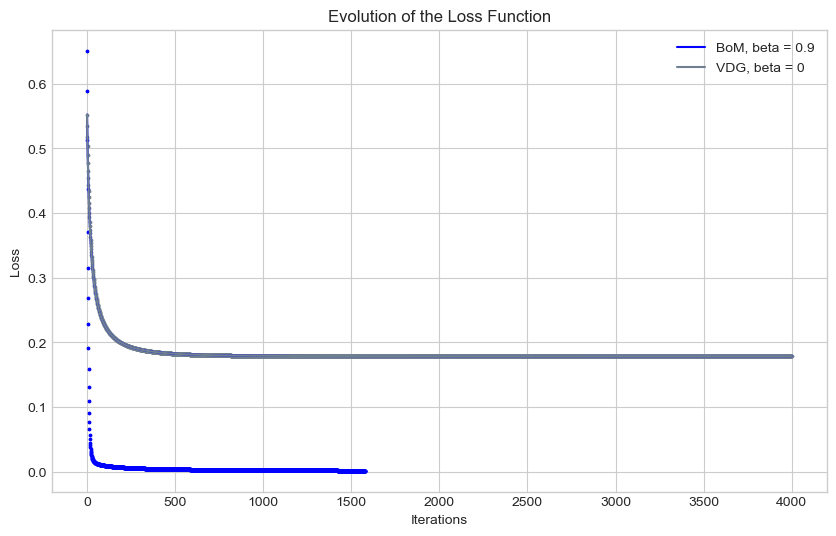

In [83]:
#first plot loss function with benefits of momentum 
plotLoss(lossVecMomentum, label = "BoM, beta = 0.9")

#add on plot of VGD
plt.plot(lossVec, color = "slategrey", label = "VDG, beta = 0")
plt.scatter(torch.arange(len(lossVec)), lossVec, color = "slategrey", s=3)
plt.gca().set(xlabel = "Iterations", ylabel = "Loss")
plt.legend()


We can see that the loss function of gradient descent with benefits of momentum (represented in blue), is decreasing faster, converging to the correct weight vector in fewer iterations than the previous experiment of vanilla gradient descent. This shows that larger non-zero beta values does allow the model to learn at a quicker rate. 

### The Dangers of Overfitting 

The last experiment I performed is to show how overfitting can be harmful, looking at its effects. I can do so by creating na instance where I obtain 100% testing accuracy, looking at data where the number of dimensions is greater than the number of points. 

We first implement the model on the training set, checking to see if our goal of 100% accuracy has been reached. 

In [89]:
#first the training set
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
X_train, y_train = classification_data(n_points = 50, noise = 0.2, p_dims = 100)
lossVecTrain = []

for index in range(4000):
    #lower alpha
    opt.step(X_train, y_train, alphaRate = 0.2, betaRate = 0.9)
    loss = LR.loss(X_train, y_train) 
    lossVecTrain.append(loss)

def accuracy(X, y):
    predictions = LR.predict(X)
    predsCorrect = (predictions == y).float()
    acc = torch.mean(predsCorrect)
    return acc

finalTrainAcc = accuracy(X_train, y_train)
print("Final Training Accuracy:", finalTrainAcc.item())


#then the testing set
X_test, y_test = classification_data(n_points = 50, noise = 0.2, p_dims = 100)
finalTestAcc = accuracy(X_test, y_test)
print("Final Testing Accuracy:", finalTestAcc.item())


#this is the same as below, just all together so i can figure out wtf is going on. need to delete later. 

Final Training Accuracy: 1.0
Final Testing Accuracy: 1.0


In [84]:
#first the training set
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
X_train, y_train = classification_data(n_points = 50, noise = 0.2, p_dims = 100)
lossVecTrain = []

for index in range(4000):
    #lower alpha
    opt.step(X_train, y_train, alphaRate = 0.2, betaRate = 0.9)
    loss = LR.loss(X_train, y_train) 
    lossVecTrain.append(loss)


In [85]:
def accuracy(X, y):
    predictions = LR.predict(X)
    predsCorrect = (predictions == y).float()
    acc = torch.mean(predsCorrect)
    return acc

finalTrainAcc = accuracy(X_train, y_train)
print("Final Training Accuracy:", finalTrainAcc.item())


Final Training Accuracy: 1.0


We can see that we have indeed achieved accuracy on the training data. 
Let's repeat the process but now on the testing data, and look at the accuracy once more. 

In [86]:
#then the testing set
X_test, y_test = classification_data(n_points = 50, noise = 0.2, p_dims = 100)
finalTestAcc = accuracy(X_test, y_test)
print("Final Testing Accuracy:", finalTestAcc.item())

Final Testing Accuracy: 1.0


The results show that the model has been overfit to the training data. Despite having 100% accuracy on the training data, the model cannot reach the same level of accuracy on the testing data, only reaching 93%. This overfit model would not perform as well as unseen data, due to its overfitting. 

### Conclusion 
Overall in this blog post, through the implementation and experimentation of a fundamental algorithm of machine learning, the logistic regression model. Through three experiements: Vanilla Gradient Descent, Benefits of Momentum, and the Dangers of Overfitting, I was able to gain insights and a deeper understanding of the behavior and performance of logistic regression models as they pertain to gradient descent, observing the effects of various changes and conditions. Visualizations served as a helpful tool in order to understand and validate the models behavior. With Vanilla Gradient Descent where beta =0 we can see that convergence does indeed occur after a certain amount of iterations. Experimenting with momentum showed the benefits of higher beta values (such as beta = 0.9), in order to increase momentum, allowing for faster convergence, outperforming the first experiment of vanilla gradient descent. Fitting the model too closely to the training data showed lower accuracy on the test data, warning against overfitting. This blog post provided me a comprehensive overview and understanding of gradient descent algorithms for logistic regression, through implementation, experimentation, and visualization. 

right now things that are wrong: 

- in overfitting my model should have lower accuracy on the testing portion, not 100 % 
- on the vanilla gd i think my loss is supposed to be smaller 

- finish conclusion and abstract 
- clean up code 